In [1]:
import os 
os.chdir('../src/')
print(os.getcwd())
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_analysis.d00_utils.load_confs import load_parameters
from traffic_viz.d06_visualisation.chunk_evaluation_plotting import (
    plot_video_stats_diff_distribution,
    plot_video_level_summary_stats,
    plot_mAP_over_time)

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
params = load_parameters()
pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src


Read in video level data

In [2]:
xml_paths = ["C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\15_2019-06-29_13-01-03.094068_00001.01252.xml",
            "C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\14_2019-06-29_13-01-19.744908_00001.05900.xml"]

video_level_df = pd.read_csv("../data/carolinetemp/video_level_df.csv",
                    dtype={"camera_id": str},
                    parse_dates=["video_upload_datetime"])
del video_level_df['Unnamed: 0']

Read in frame level data

In [3]:
frame_level_df = pd.read_csv("../data/carolinetemp/frame_level_df.csv",
                    dtype={"camera_id": str},
                    converters={"bboxes": lambda x: [float(coord) for coord in x.strip("[]").split(", ")]}, 
                    parse_dates=["video_upload_datetime"])
del frame_level_df['Unnamed: 0']

Run evaluators

In [4]:
chunk_evaluator = ChunkEvaluator(annotation_xml_paths=xml_paths,
                                 params=params,
                                 video_level_df=video_level_df,
                                 frame_level_df = frame_level_df)
video_level_stats_df, video_level_diff_df = chunk_evaluator.evaluate_video_level()
frame_level_mAP_df = chunk_evaluator.evaluate_frame_level()

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\video_level_evaluator.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  'n_videos': 'count'})
C:\Users\Caroline Wang\Anaconda3\envs\dssg\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


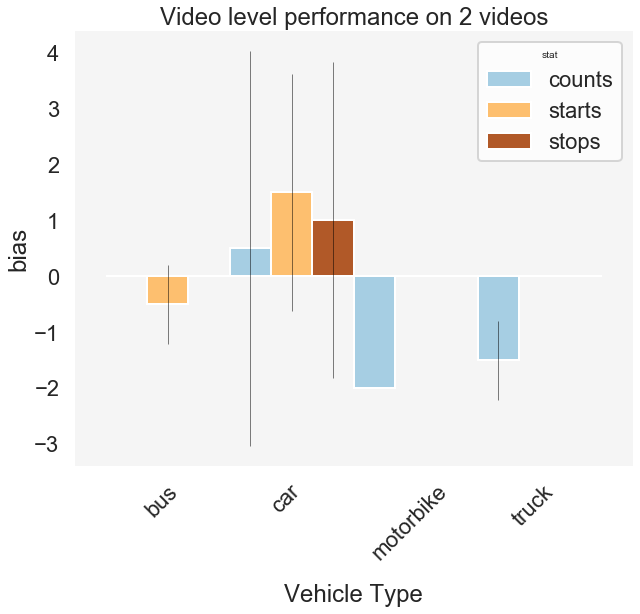

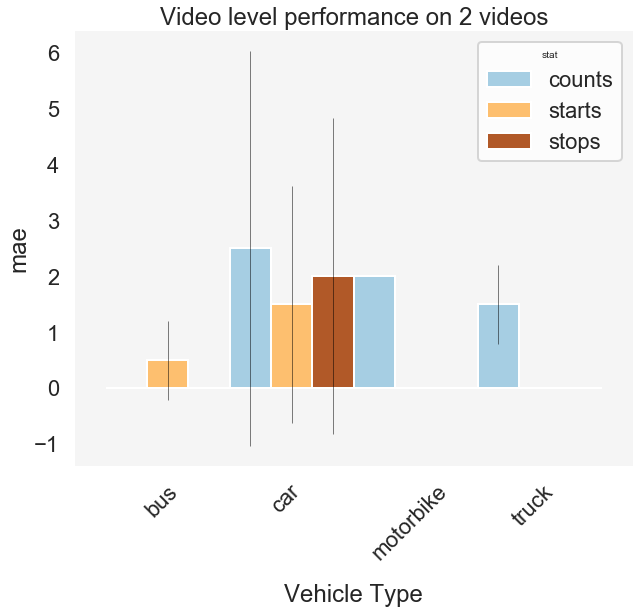

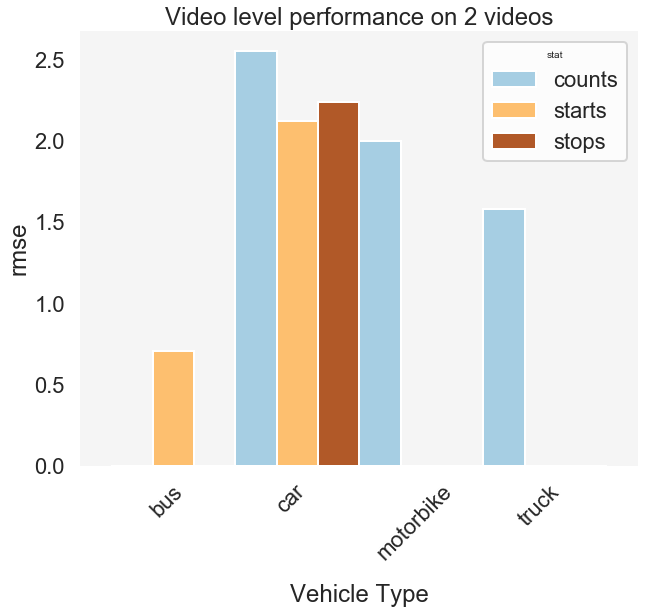

In [5]:
plot_video_level_summary_stats(video_level_stats_df, 
                       metrics = {'bias':"../data/plots/video_bias.pdf",
                                  'rmse':"../data/plots/video_rmse.pdf",
                                   'mae': "../data/plots/video_mae.pdf"})

Plot video level diffs

In [6]:
video_level_diff_df

,camera_id,video_upload_datetime,vehicle_type,counts_true,starts_true,stops_true,counts_pred,starts_pred,stops_pred,counts_diff,starts_diff,stops_diff
0,00001.01252,2019-06-29 13:01:03.094068,car,4,0,1,7.0,0.0,4.0,3.0,0.0,3.0
1,00001.01252,2019-06-29 13:01:03.094068,truck,1,0,0,0.0,0.0,0.0,-1.0,0.0,0.0
2,00001.01252,2019-06-29 13:01:03.094068,bus,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,00001.01252,2019-06-29 13:01:03.094068,motorbike,2,0,0,0.0,0.0,0.0,-2.0,0.0,0.0
4,00001.05900,2019-06-29 13:01:19.744908,car,6,1,6,4.0,4.0,5.0,-2.0,3.0,-1.0
5,00001.05900,2019-06-29 13:01:19.744908,truck,2,0,0,0.0,0.0,0.0,-2.0,0.0,0.0
6,00001.05900,2019-06-29 13:01:19.744908,bus,1,1,0,1.0,0.0,0.0,0.0,-1.0,0.0
7,00001.05900,2019-06-29 13:01:19.744908,motorbike,2,0,0,0.0,0.0,0.0,-2.0,0.0,0.0


In [8]:
def plot_video_stats_diff_distribution(video_level_diff_df: pd.DataFrame,
                                       video_stat_types: list, 
                                       show_plot: bool = True,
                                       save_path: str = None):
    """For each statistic type (counts, starts, stops, etc.) plots the
    distribution of difference from ground truth for each vehicle type

    Args:
        video_level_diff_df: the output of ChunkEvaluator.evaluate_video_level()
        video_stat_types: list of video level stats computed (pass from params)
        show_plot: If true, will display the plot
        save_path: if specified, will save to this location (specify full path with
        desired filename)
    """
    plt.style.use('seaborn-deep')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,20))
    
    for i,stat_type in enumerate(video_stat_types):
        stat_list = []
        vehicle_types=[]
        for vehicle_type, vehicle_group_df in video_level_diff_df.groupby("vehicle_type"):
            stat_list.append(vehicle_group_df[f"{stat_type}_diff"])
            vehicle_types.append(vehicle_type)

        # plot distribution of stat_type on one sub-plot
        ax = eval(f"ax{i+1}")
        ax.set_title(stat_type)
        ax.hist(x=stat_list, 
                label=vehicle_types,
                alpha=0.8)
        ax.legend(loc="upper right")

    fig.suptitle("Distribution of Differences for Traffic Statistics", size=24)
    fig.text(0, 0.5,"Frequency", ha='center', va='center', rotation='vertical', size=24) #y label
    fig.text(0.5, 0, "Model Prediction", ha='center', va='center', size=24) # x label

    fig.tight_layout()
    fig.subplots_adjust(top=0.90, 
                        left = 0.05,
                        right= 0.90,
                        bottom = 0.05
                       )
    if save_path is not None: 
        plt.savefig(save_path)
    if show_plot: 
        plt.show()
    plt.close()

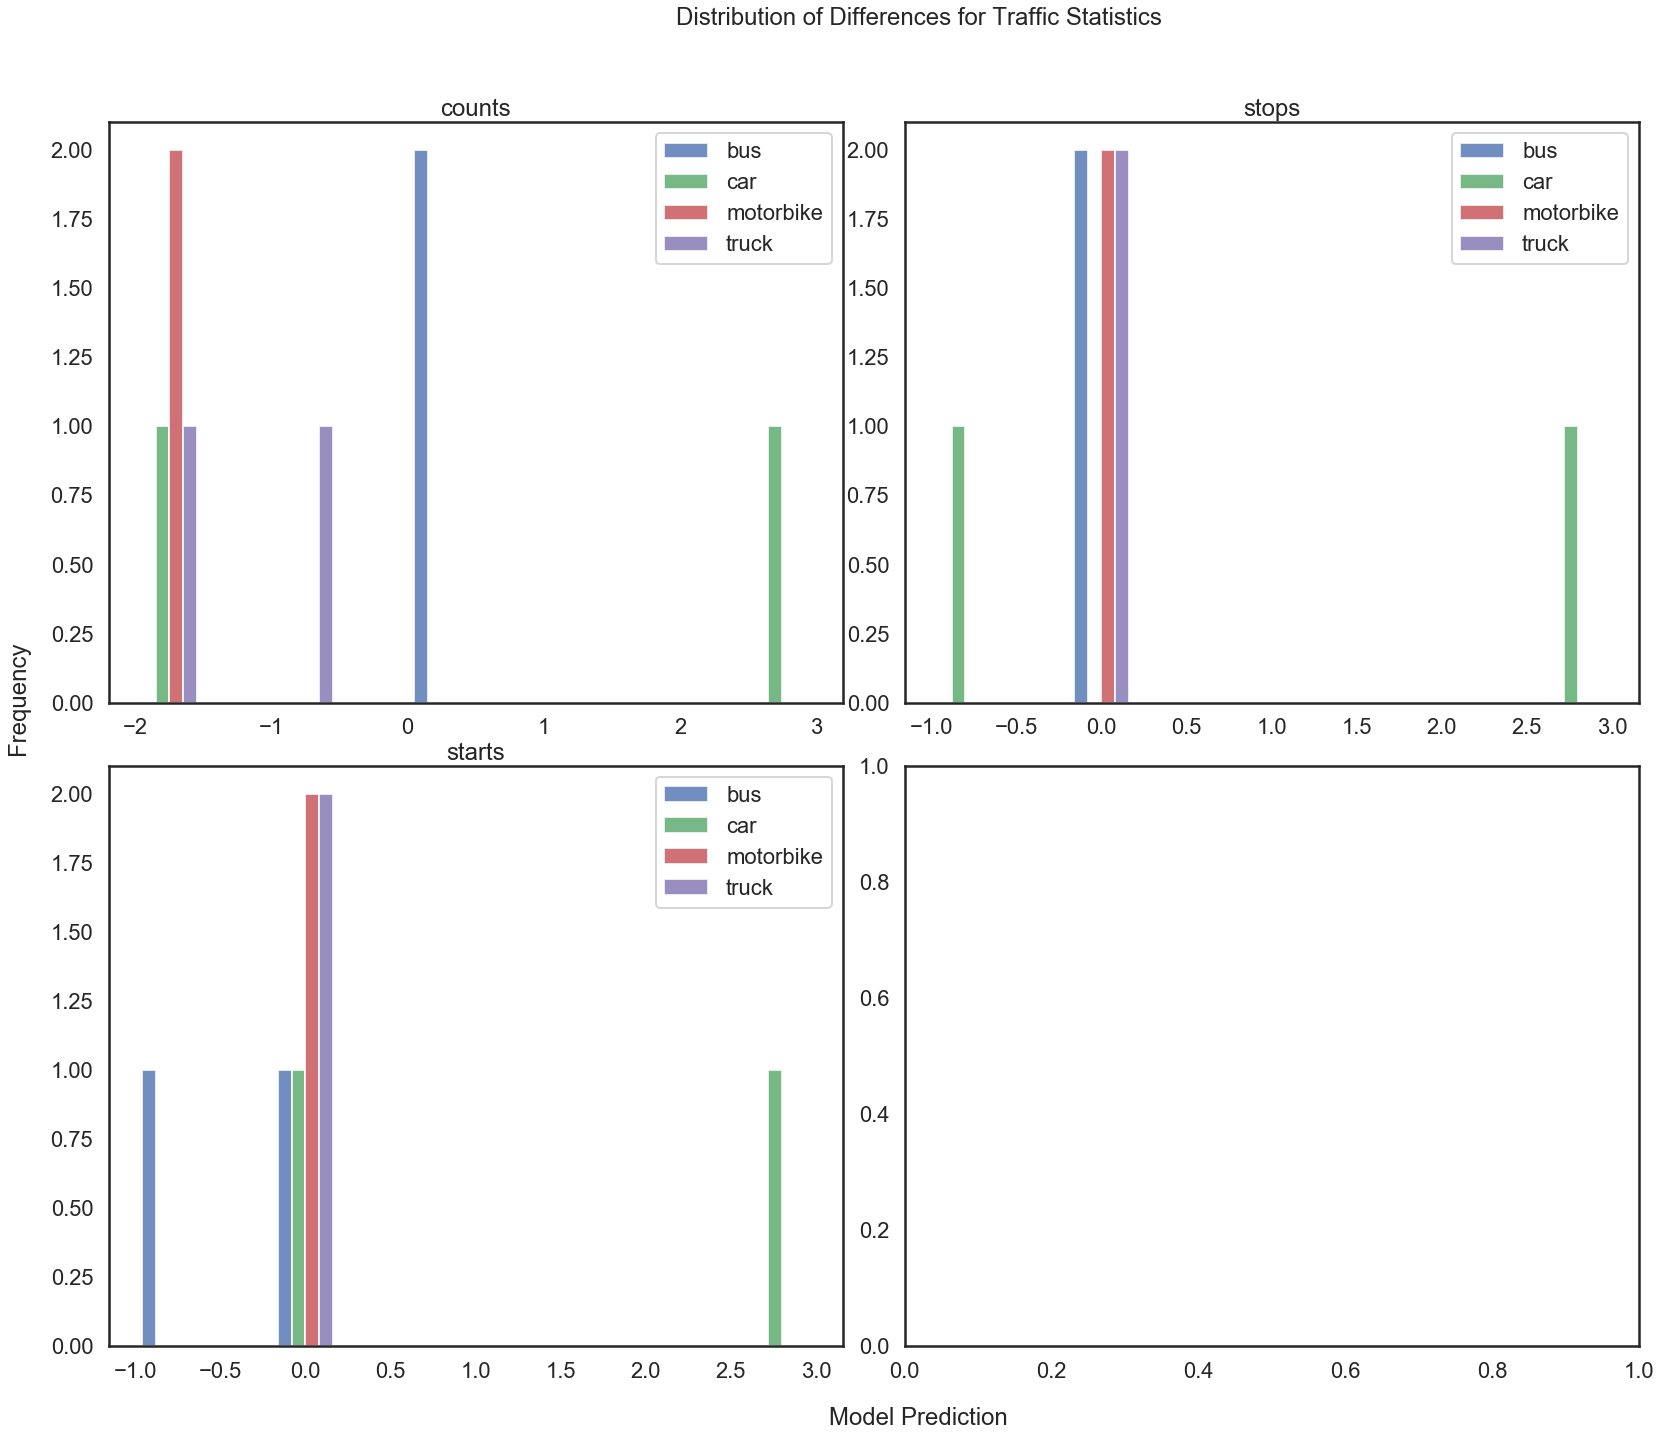

In [9]:
plot_video_stats_diff_distribution(video_level_diff_df,video_stat_types = ["counts", "stops", "starts"],
                                  save_path = "../data/plots/diff_dist.pdf")

## Frame Level Plotting

In [ ]:
frame_level_mAP_df

In [ ]:
plot_mAP_over_time(frame_level_mAP_df,
                   save_path = "../data/plots/map_over_time.pdf"
                  )